In [1]:
# Imports
import numpy as np
from skimage import io, img_as_float32, color, feature
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, convolve
import cv2

# plot function
def show_plot(plot_title, plot):
  plt.imshow(plot, cmap='gray')
  plt.title(plot_title)
  plt.show()

# gaussian kernel function
def create_kernel(sigma):
  size = 2 * int(np.ceil(3 * sigma)) + 1
  kernel = np.zeros((size, size))
  kernel[size//2, size//2] = 1
  return gaussian_filter(kernel, sigma)

# load image function
def load_image(image):
  I = img_as_float32(io.imread(image))
  # shape to RGB
  if I.shape[2] == 4:
    I = I[:, :, :3]
  # return original image and gray image
  return I, color.rgb2gray(I)

# Problem 1

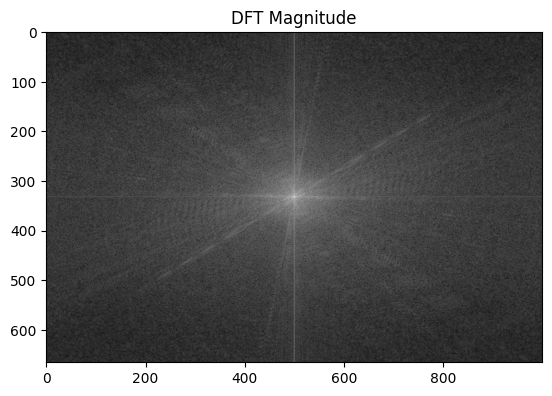

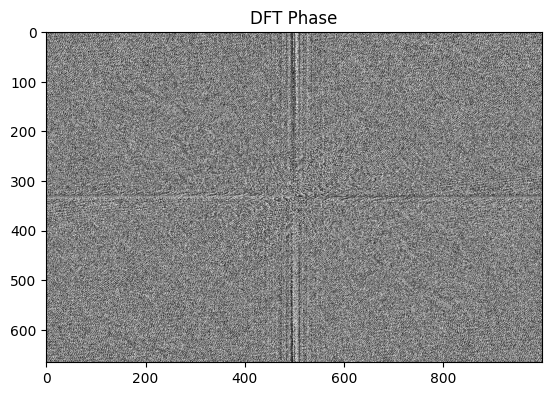

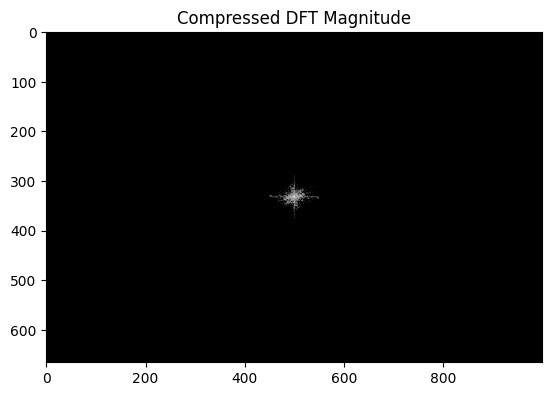

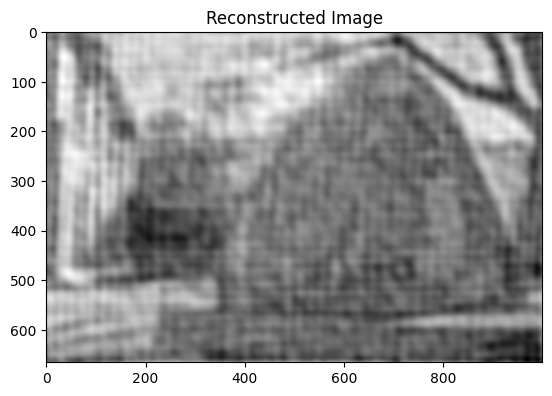

Original image has 666000 pixels.
DFT compression keeps 1000 elements.
Compression ratio is 0.001502


In [2]:
I, I_gray = load_image('mines.png')

# Compute the Fourier transform, DFT mag, phase
I_dft = np.fft.fftshift(np.fft.fft2(I_gray))
I_mag = np.abs(I_dft)
I_phase = np.angle(I_dft)

# Create a mask
compressed_element_count = 1000
sorted_indices = np.argsort(I_mag.flatten())[::-1]
top_1000_indices = sorted_indices[:compressed_element_count]
mask = np.zeros_like(I_mag).flatten()
mask[top_1000_indices] = 1
mask = mask.reshape(I_mag.shape)

# Compress, reconstruct
I_dft_compressed = I_dft * mask
I_mag_compressed = np.abs(I_dft_compressed)
I_reconstructed =   np.real(np.fft.ifft2(np.fft.ifftshift(I_dft_compressed)))

# Show results
show_plot("DFT Magnitude", (np.log(I_mag + 1)))
show_plot("DFT Phase", I_phase)
show_plot("Compressed DFT Magnitude", (np.log(I_mag_compressed + 1)))
show_plot("Reconstructed Image", (np.log(I_reconstructed+1)))

# Answer questions
original_pixel_count = I_gray.size  # height * width
compression_ratio = compressed_element_count / original_pixel_count
print(f"Original image has {original_pixel_count} pixels.")
print(f"DFT compression keeps {compressed_element_count} elements.")
print(f"Compression ratio is {compression_ratio:.6f}")

# Problem 2

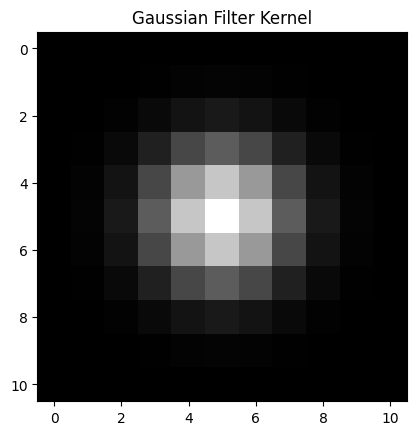

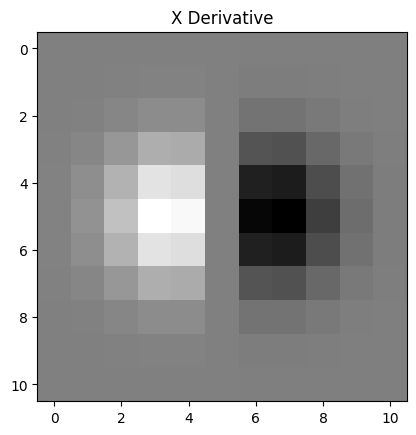

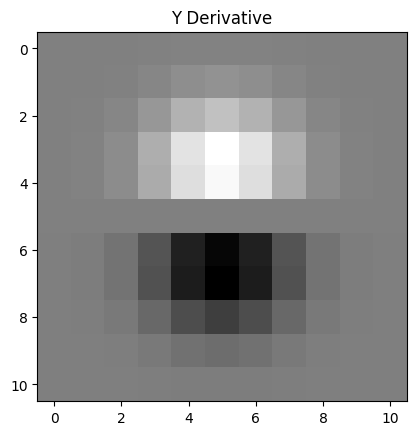

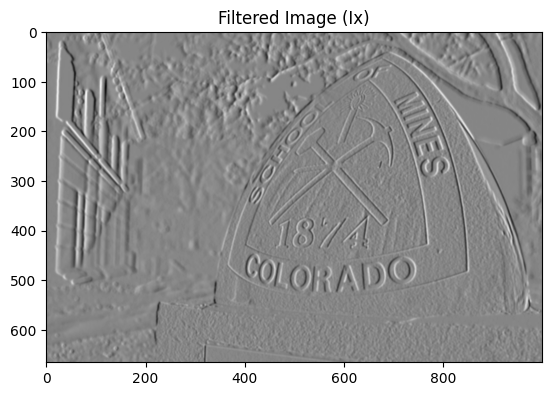

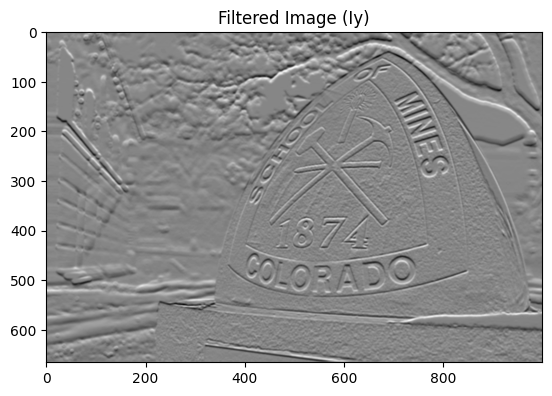

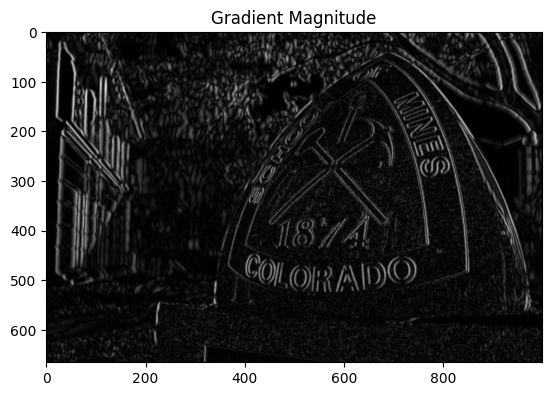

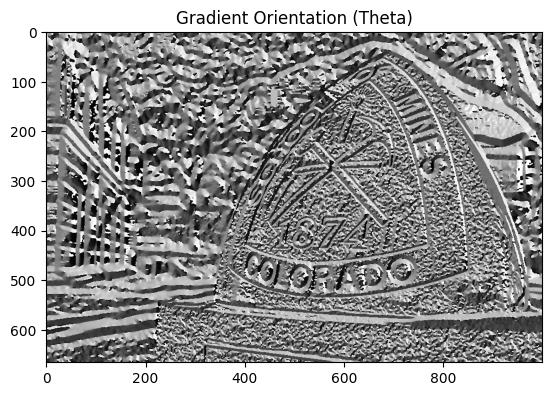

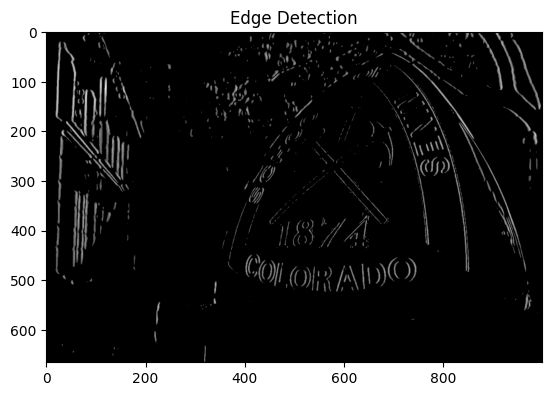

In [3]:
I, I_gray = load_image('mines.png')

# Create a Gaussian filter kernel with σ = 1.4
kernel = create_kernel(1.4)

# Convolve the kernel with 1D derivate filters
dx_filter = np.array([[1, 0, -1]])
dy_filter = np.array([[1], [0], [-1]])
x_deriv = convolve(kernel, dx_filter)
y_deriv = convolve(kernel, dy_filter)

# Compute image gradients, magnitude, orientation
I_x = convolve(I_gray, x_deriv)
I_y = convolve(I_gray, y_deriv)
magnitude = np.sqrt(I_x**2, I_y**2)
orientation = np.arctan2(I_y, I_x)

# Show result
show_plot("Gaussian Filter Kernel", kernel)
show_plot("X Derivative", x_deriv)
show_plot("Y Derivative", y_deriv)
show_plot("Filtered Image (Ix)", I_x)
show_plot("Filtered Image (Iy)", I_y)
show_plot("Gradient Magnitude", magnitude)
show_plot("Gradient Orientation (Theta)", orientation)

#Remove pixels below a certain threshold
threshold = .08
edges = np.where(magnitude > threshold, magnitude, 0)
show_plot("Edge Detection", edges)


# PROBLEM 3

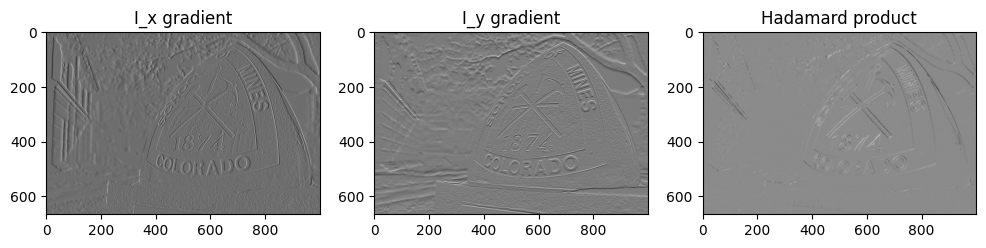

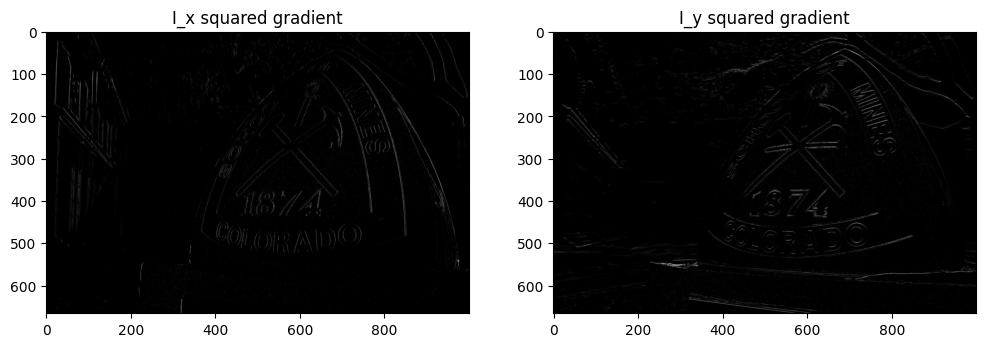

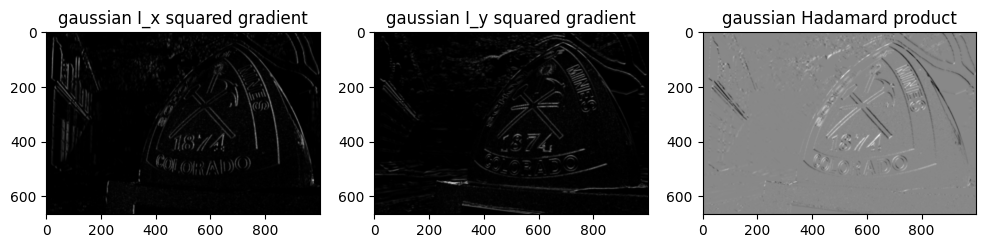

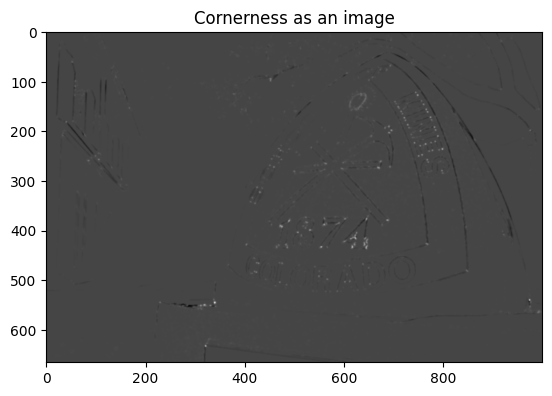

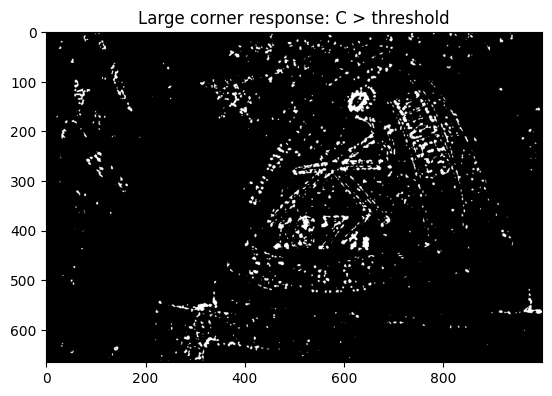

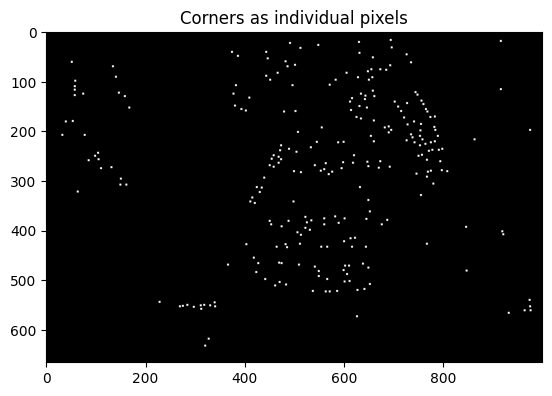

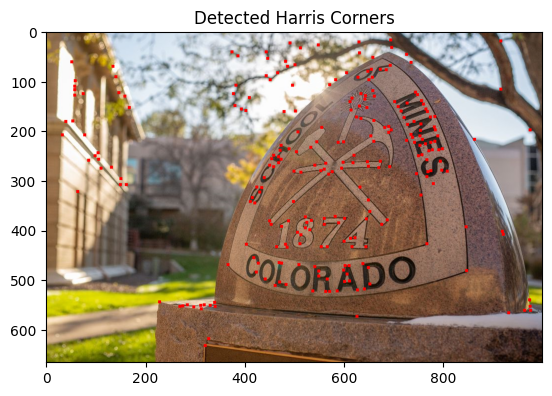

In [4]:
I, I_gray = load_image('mines.png')

# create Sobel filters
x_kernel = np.array([[-1, 0, 1],
                     [-2, 0, 2],
                     [-1, 0, 1]])
y_kernel = np.array([[-1, -2, -1],
                     [ 0,  0,  0],
                     [ 1,  2,  1]])

# compute image gradients
I_x = convolve(I_gray, x_kernel)
I_y = convolve(I_gray, y_kernel)

# find Hadamard product
dot_prod = np.multiply(I_x, I_y)

# display I_x, I_y, and I_x dot I_y
figure, (plot1, plot2, plot3) = plt.subplots(1, 3, figsize=(12, 5))
plot1.imshow(I_x, cmap='gray') # use log scaling for magnitude
plot1.set_title('I_x gradient')
plot2.imshow(I_y, cmap='gray')
plot2.set_title('I_y gradient')
plot3.imshow(dot_prod, cmap='gray')
plot3.set_title('Hadamard product')
plt.show()

# compute M componenets as squares of derivatives
I_x2 = I_x ** 2
I_y2 = I_y ** 2

# display
figure, (plot1, plot2) = plt.subplots(1, 2, figsize=(12, 5))
plot1.imshow(I_x2, cmap='gray')
plot1.set_title('I_x squared gradient')
plot2.imshow(I_y2, cmap='gray')
plot2.set_title('I_y squared gradient')
plt.show()

# Gaussian filter
kernel = create_kernel(1.4)

# convolve I_x_sq, I_y_sq, and I_x dot I_y with Gaussian
gaussian_I_x2 = convolve(I_x2, kernel)
gaussian_I_y2 = convolve(I_y2, kernel)
gaussian_hadamard = convolve(dot_prod, kernel)

# display
figure, (plot1, plot2, plot3) = plt.subplots(1, 3, figsize=(12, 5))
plot1.imshow(gaussian_I_x2, cmap='gray') # use log scaling for magnitude
plot1.set_title('gaussian I_x squared gradient')
plot2.imshow(gaussian_I_y2, cmap='gray')
plot2.set_title('gaussian I_y squared gradient')
plot3.imshow(gaussian_hadamard, cmap='gray')
plot3.set_title('gaussian Hadamard product')
plt.show()

# compute cornerness
alpha = 0.04
C = np.multiply(gaussian_I_x2, gaussian_I_y2) - gaussian_hadamard ** 2 - alpha * ((gaussian_I_x2 + gaussian_I_y2) ** 2)

# display cornerness
show_plot("Cornerness as an image", C)

# create a threshold that of maximum cornerness score
threshold = 0.01 * C.max()
x = I_gray.shape[0]
y = I_gray.shape[1]
threshold_im = np.zeros_like(I_gray)
for i in range(x):
  for j in range(y):
    if C[i][j] >= threshold:
      threshold_im[i][j] = 255

# display threshed C
show_plot("Large corner response: C > threshold", threshold_im)

# use non-maximum suppression (with appropriate threshold) to pick corners as individual pixels
new_threshold = 0.05 * C.max()
non_max_suppression = np.zeros_like(I_gray)
for i in range(6, x - 10):
  for j in range(6, y - 10):
    if C[i][j] >= new_threshold:
      if C[i][j] == C[i-5:i+5, j-5:j+5].max():
        non_max_suppression[i-2:i+2, j-2:j+2] = 255

# display non-maximum suppression
show_plot("Corners as individual pixels", non_max_suppression)

# display corners overlapped on the original image
coordinates = np.where(non_max_suppression > 0)
I_corners = np.copy(I)
for i in range(len(coordinates[0])):
  y, x = coordinates[0][i], coordinates[1][i]
  I_corners[max(y-1,0):min(y+2,I.shape[0]), max(x-1,0):min(x+2,I.shape[1]), :] = [1,0,0]
show_plot("Detected Harris Corners", I_corners)



# PROBLEM 4

Number of corners detected: 174


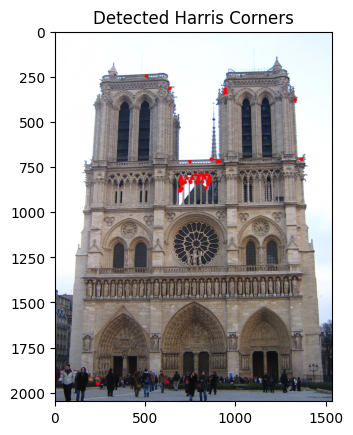

Dominant Orientation: 260 degrees


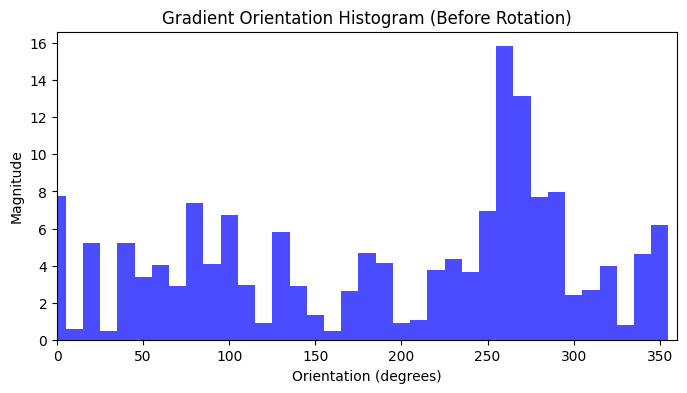

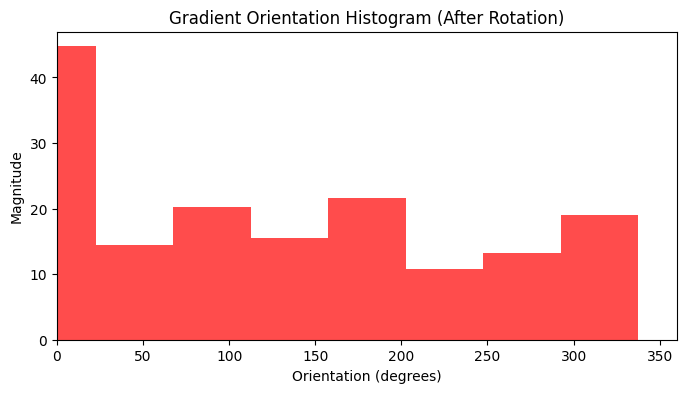

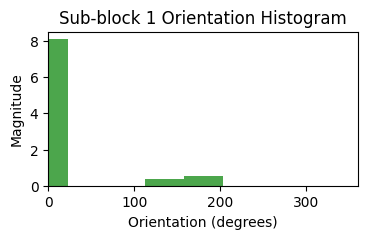

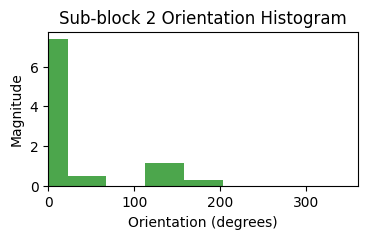

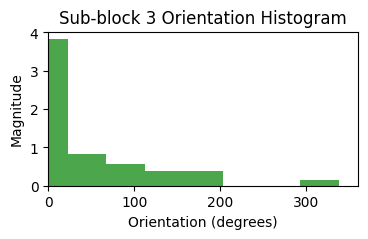

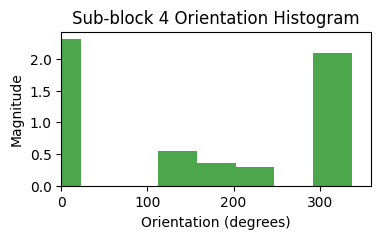

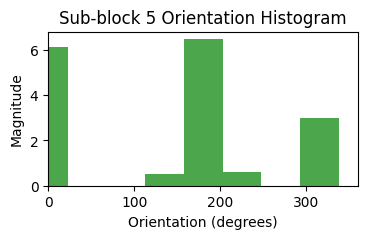

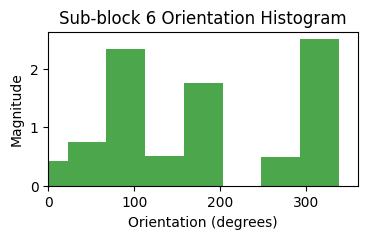

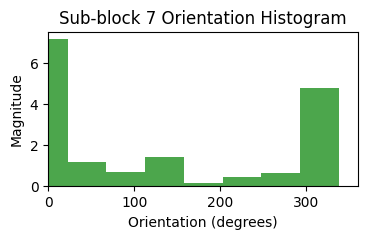

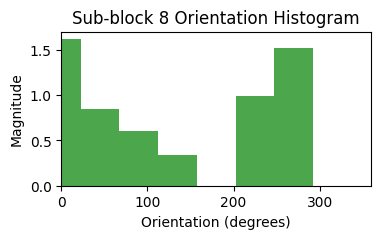

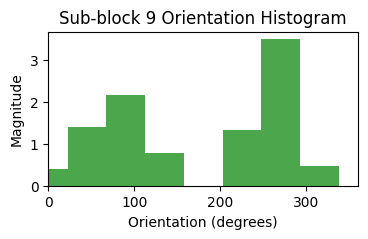

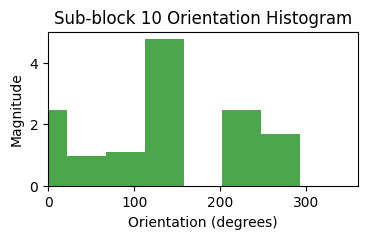

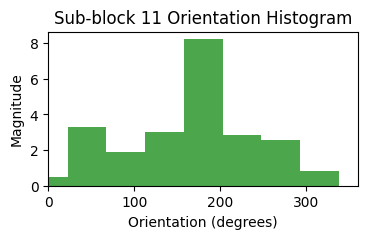

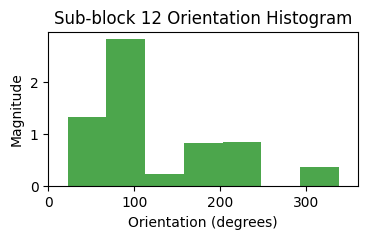

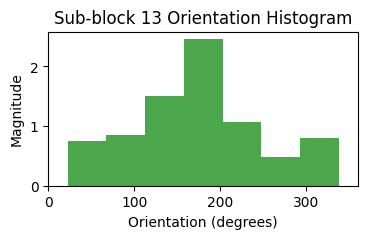

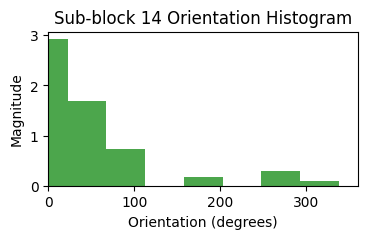

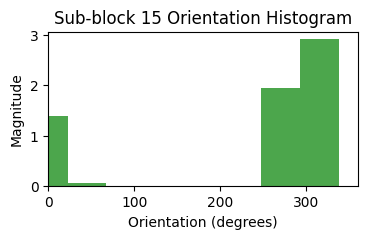

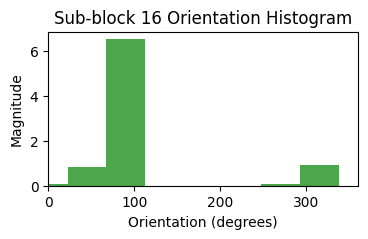

128-element SIFT descriptor:
[8.10768729 0.         0.         0.37612873 0.5346465  0.
 0.         0.         7.38408896 0.47259232 0.         1.16280034
 0.30709097 0.         0.         0.         3.82745329 0.81718228
 0.57494682 0.3801122  0.39150016 0.         0.         0.1572862
 2.31489165 0.         0.         0.54822484 0.35884938 0.29717052
 0.         2.09642866 6.12892258 0.         0.         0.53956527
 6.48380429 0.60251665 0.         2.97578222 0.42614865 0.74510716
 2.33133048 0.51334316 1.75120151 0.         0.48783547 2.5034959
 7.19230598 1.17419076 0.66915941 1.41629231 0.14166802 0.42394197
 0.60134828 4.78339406 1.62076099 0.84446116 0.60184276 0.33738154
 0.         0.98635273 1.51734422 0.         0.40497515 1.40275192
 2.16197269 0.77032924 0.         1.33263415 3.50377169 0.47090656
 2.46333194 0.96818712 1.10447192 4.76685363 0.         2.47026867
 1.68580401 0.         0.46453515 3.31552792 1.88298011 2.98941076
 8.23169744 2.8294948  2.55990598 0.8381201

In [5]:
# Find corners using harris detector
def find_corners(image, image_gray, threshold):
  corners = feature.corner_harris(image_gray)
  binary_corners = corners > (threshold * corners.max())
  coordinates = np.argwhere(binary_corners)
  print(f"Number of corners detected: {len(coordinates)}")
  # Visualize corners on the original image
  I_corners = np.copy(image)
  for coord in coordinates:
      cv2.circle(I_corners, (coord[1], coord[0]), 10, (1, 0, 0), -1)
  I_corners_uint8 = (I_corners * 255).astype(np.uint8)
  show_plot("Detected Harris Corners", I_corners_uint8)
  return coordinates

# SIFT function
def SIFT(I_x, I_y, coordinates, print_corner):
  degrees = 10
  num_bins = 36
  half_size = 8
  histogram_arr = []
  sub_size = 4
  bin_degrees = 360 / 8
  last_hist = np.zeros(num_bins)
  last_rotated = 0
  # Loop through each corner
  for y, x in coordinates:
    if x > half_size and y > half_size and x < I_x.shape[1] - half_size and y < I_x.shape[0] - half_size:
      # Extract the 16x16 window around the corner
      window_Ix = I_x[y-half_size:y+half_size, x-half_size:x+half_size]
      window_Iy = I_y[y-half_size:y+half_size, x-half_size:x+half_size]

      window_magnitude = np.sqrt(window_Ix**2 + window_Iy**2)
      window_orientation = np.degrees(np.arctan2(window_Iy, window_Ix)) % 360

      # Create a histogram for this window
      this_hist = np.zeros(num_bins)

      # Loop through each pixel in the 16x16 window and accumulate into histogram
      for i in range(16):
        for j in range(16):
          angle = window_orientation[i, j]
          magnitude = window_magnitude[i, j]
          bin_idx = int(angle // degrees) % num_bins  # Ensure bin index is within bounds
          this_hist[bin_idx] += magnitude  # Accumulate magnitude for that bin

      # Find dominant orientation
      dom_angle = np.argmax(this_hist) * degrees

      # Print
      if print_corner:
        print(f"Dominant Orientation: {dom_angle} degrees")
        # Display the gradient orientation histogram before rotation
        plt.figure(figsize=(8, 4))
        plt.bar(np.arange(num_bins) * degrees, this_hist, width=degrees, color='b', alpha=0.7)
        plt.title('Gradient Orientation Histogram (Before Rotation)')
        plt.xlabel('Orientation (degrees)')
        plt.ylabel('Magnitude')
        plt.xlim(0, 360)
        plt.show()

      # Rotate the orientation values by subtracting the dominant angle
      rotated_orientation = (window_orientation - dom_angle) % 360

      sift_descriptor = []  # Reset for each corner

      # Print
      if print_corner:
        sub_histograms = []  # For visualizing each 4x4 sub-block histogram

      for i in range(0, 16, sub_size):
        for j in range(0, 16, sub_size):
          # Extract 4x4 sub-block
          sub_block_orientation = rotated_orientation[i:i + sub_size, j:j + sub_size]
          sub_block_magnitude = window_magnitude[i:i + sub_size, j:j + sub_size]

          # Compute an 8-bin histogram for the sub-block
          sub_hist = np.zeros(8)
          angles_flat = sub_block_orientation.ravel()
          magnitudes_flat = sub_block_magnitude.ravel()

          for idx in range(angles_flat.size):
            angle = angles_flat[idx]
            magnitude = magnitudes_flat[idx]
            sub_bin_idx = int(angle // bin_degrees) % 8  # Ensure sub-bin index is within bounds
            sub_hist[sub_bin_idx] += magnitude

          # Append the sub-block histogram to the descriptor list
          sift_descriptor.append(sub_hist)

          # Print
          if print_corner:
            sub_histograms.append(sub_hist)

      # Print
      if print_corner:
        # Re-compute and display the gradient orientation histogram after rotation
        rotated_hist = np.zeros(8)
        for idx in range(rotated_orientation.ravel().size):
            angle = rotated_orientation.ravel()[idx]
            magnitude = window_magnitude.ravel()[idx]
            bin_idx = int(angle // bin_degrees) % 8
            rotated_hist[bin_idx] += magnitude

        plt.figure(figsize=(8, 4))
        plt.bar(np.arange(8) * bin_degrees, rotated_hist, width=bin_degrees, color='r', alpha=0.7)
        plt.title('Gradient Orientation Histogram (After Rotation)')
        plt.xlabel('Orientation (degrees)')
        plt.ylabel('Magnitude')
        plt.xlim(0, 360)
        plt.show()

        # Display the 8-bin histogram for each 4x4 sub-block (total 16 histograms)
        for idx, sub_hist in enumerate(sub_histograms):
            plt.figure(figsize=(4, 2))
            plt.bar(np.arange(8) * bin_degrees, sub_hist, width=bin_degrees, color='g', alpha=0.7)
            plt.title(f'Sub-block {idx + 1} Orientation Histogram')
            plt.xlabel('Orientation (degrees)')
            plt.ylabel('Magnitude')
            plt.xlim(0, 360)
            plt.show()

      # Flatten the list of sub-histograms into a single 128-element vector
      sift_descriptor = np.concatenate(sift_descriptor)

      # Print
      if print_corner:
        print("128-element SIFT descriptor:")
        print(sift_descriptor)

      # Normalize the descriptor (to the range 0-1)
      if np.max(sift_descriptor) > 0:
          sift_descriptor = sift_descriptor / np.max(sift_descriptor)

      # Print
      if print_corner:
        print("Normalized SIFT descriptor:")
        print(sift_descriptor)

      # Clamp and re-normalize the descriptor
      sift_descriptor[sift_descriptor > 0.2] = 0.2
      if np.sum(sift_descriptor) > 0:
          sift_descriptor = sift_descriptor / np.sum(sift_descriptor)

      # Print
      if print_corner:
        print("Re-normalized SIFT descriptor:")
        print(sift_descriptor)
        print_corner = False

      # Store the descriptor for this corner
      histogram_arr.append(sift_descriptor)
      last_hist =  this_hist
      last_rotated = window_orientation

  # Return all feature descriptors
  return histogram_arr

# Run function (for problem 5 convenience)
def run_SIFT(image, corner_threshold, print_corner):
  # load images
  I, I_gray = load_image(image)
  # create Sobel filters
  x_kernel = np.array([[-1, 0, 1],
                      [-2, 0, 2],
                      [-1, 0, 1]])
  y_kernel = np.array([[-1, -2, -1],
                      [ 0,  0,  0],
                      [ 1,  2,  1]])
  # Compute image gradients
  I_x = convolve(I_gray, x_kernel)
  I_y = convolve(I_gray, y_kernel)
  # Get corners
  coordinates = find_corners(I, I_gray, corner_threshold)
  # Run the SIFT algorithm
  h = SIFT(I_x, I_y, coordinates, print_corner)
  return I, coordinates, h

# Run SIFT
I, c, h = run_SIFT('image1.jpg', 0.25, True)

# PROBLEM 5

Number of corners detected: 633


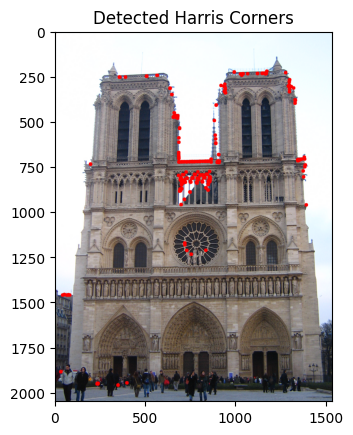

Number of corners detected: 1415


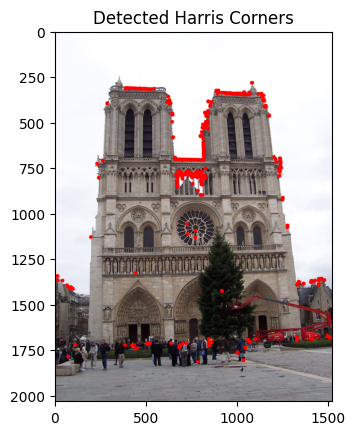

Bidirectional matches: [(1, 80), (2, 83), (6, 117), (8, 111), (13, 275), (15, 33), (16, 243), (18, 246), (22, 154), (40, 63), (42, 630), (43, 683), (44, 632), (45, 633), (47, 576), (50, 689), (51, 227), (72, 352), (94, 871), (98, 384), (100, 505), (101, 506), (110, 473), (160, 288), (193, 115), (194, 128), (208, 261), (230, 141), (235, 297), (247, 1136), (249, 721), (281, 732), (302, 277), (347, 793), (350, 285), (352, 252), (401, 1259), (431, 284), (441, 474), (464, 347), (484, 908), (535, 1119), (545, 1085), (546, 1124), (547, 1089), (555, 713), (560, 371), (583, 305), (606, 1222)]


In [6]:
def compute_distances(h1, h2):
    h1 = np.array(h1)
    h2 = np.array(h2)
    # Calculate the dot product matrix
    dot_product = np.dot(h1, h2.T)
    # Calculate the squared norms of each descriptor
    norm_h1 = np.sum(h1**2, axis=1, keepdims=True)
    norm_h2 = np.sum(h2**2, axis=1)
    # Use broadcasting to compute the squared distances
    distances = norm_h1 + norm_h2 - 2 * dot_product
    # Ensure no negative distances due to numerical instability
    distances = np.maximum(distances, 0)
    # Take the square root to get L2 distances
    distances = np.sqrt(distances)
    return distances

def match_keypoints(h1, h2):
    distances = compute_distances(h1, h2)
    matches1_to_2 = np.argmin(distances, axis=1)  # Closest keypoint in h2 for each keypoint in h1
    matches2_to_1 = np.argmin(distances, axis=0)  # Closest keypoint in h1 for each keypoint in h2
    # print("Matches 1 to 2", matches1_to_2)
    # print("Matches 2 to 1", matches2_to_1)
    return matches1_to_2, matches2_to_1

def find_bidirectional_matches(matches1_to_2, matches2_to_1):
    bidirectional_matches = []
    for i, match_in_h2 in enumerate(matches1_to_2):
        if matches2_to_1[match_in_h2] == i:
            bidirectional_matches.append((i, match_in_h2))  # (keypoint index in h1, keypoint index in h2)
    return bidirectional_matches

# Get keypoints and feature descriptors
I1, k1, h1 = run_SIFT('image1.jpg', 0.15, False)
I2, k2, h2 = run_SIFT('image2.jpg', 0.15, False)

# compute matches
m12, m21 = match_keypoints(h1,h2)
matches = find_bidirectional_matches(m12, m21)
print("Bidirectional matches:", matches)

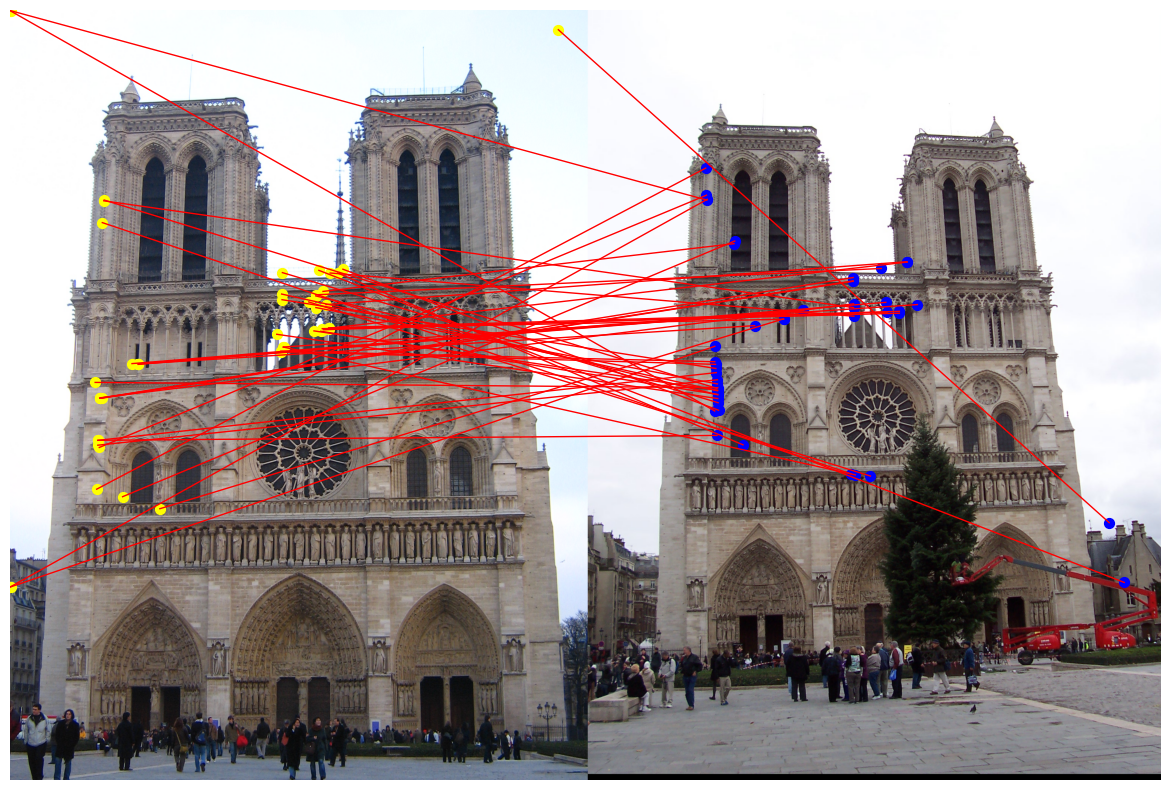

In [7]:
def draw_matches(image1, image2, keypoints1, keypoints2, matches):
    h1, w1, _ = image1.shape
    h2, w2, _ = image2.shape

    # Create a canvas large enough to hold both images side by side
    new_height = max(h1, h2)
    new_width = w1 + w2
    canvas = np.zeros((new_height, new_width, 3), dtype=np.float32)

    # Copy both images into the canvas
    canvas[:h1, :w1, :] = image1  # Place image1 on the left
    canvas[:h2, w1:w1 + w2, :] = image2  # Place image2 on the right

    # Create a figure and axis for the plot
    plt.figure(figsize=(15, 10))
    plt.imshow(canvas, aspect='equal')
    plt.axis('off')

    # Draw lines connecting matched keypoints
    for match in matches:
        idx1, idx2 = match
        # Get keypoint positions
        point1 = (int(keypoints1[idx1][0]), int(keypoints1[idx1][1]))  # x, y in image1
        point2 = (int(keypoints2[idx2][0]) + w1, int(keypoints2[idx2][1]))  # x, y in image2 (shifted by image1 width)

        # Draw line
        plt.plot([point1[0], point2[0]], [point1[1], point2[1]], 'r-', linewidth=1)

        # Draw keypoints for matched points only
        plt.scatter(point1[0], point1[1], color='yellow', s=50)  # Keypoint in image1
        plt.scatter(point2[0], point2[1], color='blue', s=50)  # Keypoint in image2

    plt.show()

# make the plot
draw_matches(I1, I2, k1, k2, matches)

Number of corners detected: 633


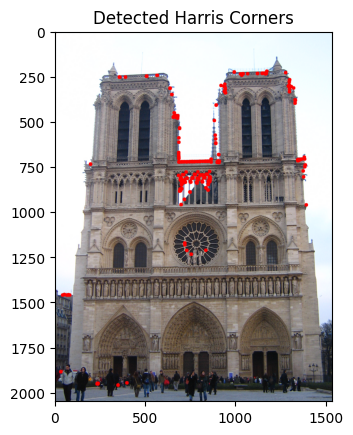

Number of corners detected: 1415


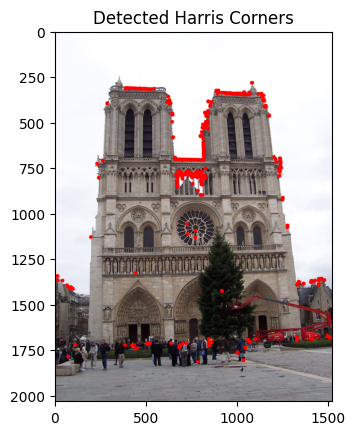

Bidirectional matches: [(42, 630), (45, 633), (101, 506), (208, 261), (249, 721), (281, 732), (545, 1085), (546, 1124), (583, 305), (606, 1222)]


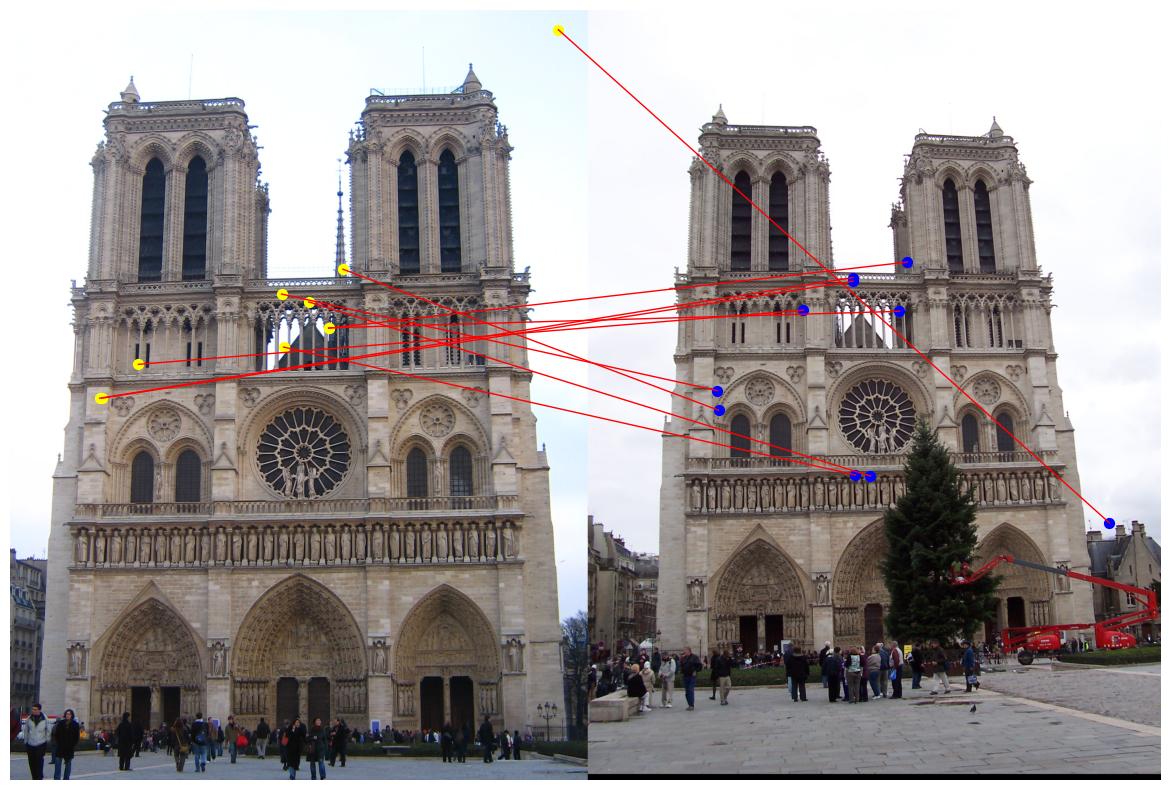

In [8]:
def match_keypoints_with_lowe_ratio(h1, h2, ratio_threshold=0.95):
    distances = compute_distances(h1, h2)

    # Find the closest (NN1) and second-closest (NN2) keypoints
    nn1_indices = np.argmin(distances, axis=1)
    nn1_distances = distances[np.arange(distances.shape[0]), nn1_indices]
    # print("nn1_indices", nn1_indices)
    # print("nn1_distances", nn1_distances)

    # Remove the closest matches to find the second-closest
    distances[np.arange(distances.shape[0]), nn1_indices] = np.inf
    nn2_indices = np.argmin(distances, axis=1)
    nn2_distances = distances[np.arange(distances.shape[0]), nn2_indices]
    # print("nn2_indices", nn2_indices)
    # print("nn1_distances", nn1_distances)

    # Calculate Lowe's ratio
    ratios = nn1_distances / nn2_distances
    # print("ratios", ratios)

    # Create an array to store the results
    result_matches = np.full(nn1_indices.shape, -1)  # Initialize with -1

    # Fill the result array with valid nn1_indices where the ratio is within the threshold
    valid_matches = ratios < ratio_threshold
    result_matches[valid_matches] = nn1_indices[valid_matches]  # Put the indices where the ratio is valid
    # print("result_matches", result_matches)

    return result_matches  # Return the array of matches

def find_bidirectional_matches(matches1_to_2, matches2_to_1):
    bidirectional_matches = []
    for i, match_in_h2 in enumerate(matches1_to_2):
        if match_in_h2 != -1:
          if matches2_to_1[match_in_h2] == i:
              bidirectional_matches.append((i, match_in_h2))  # (keypoint index in h1, keypoint index in h2)
    return bidirectional_matches

# Get keypoints and feature descriptors
I1, k1, h1 = run_SIFT('image1.jpg', 0.15, False)
I2, k2, h2 = run_SIFT('image2.jpg', 0.15, False)

# Compute matches with Lowe's ratio test
m12 = match_keypoints_with_lowe_ratio(h1, h2)
m21 = match_keypoints_with_lowe_ratio(h2, h1)

# Find bidirectional matches
matches = find_bidirectional_matches(m12, m21)
print("Bidirectional matches:", matches)

# make the plot
draw_matches(I1, I2, k1, k2, matches)

# PROBLEM 5 EXPLANATIONS

1. Did you get the same matchings from image1 to image2 and vice versa? If yes, do you think that will always be the case? If no, explain why they can be different.

I did not get the same matches. They can be different, for example, when one image thinks there is a good match and maps one of its keypoints to a keypoint in the other image. But in the other image, that keypoint gets mapped to a different keypoint in the first image, because an even better match was found going from the opposite direction.

2. Are all keypoints matched correctly across the 2 images? If yes, will that always be the case? If no, why wrong matching happens?

No. Wrong matching happens when feature descriptors at certain points are very similar to each other despite not actually being for the same keypoint across images. Practically, this can happen when the images are not perfectly aligned, when there are new objects in the frame, change in lighting, etc..

3. What is the difference between previous results and the results with Lowe’s ratio?

I got way less matches using Lowe's ratio. It seems that lots of my feature descriptors are too similar for the ratio to be significant. With a threshold of 0.7, I actually got zero matches, even when setting the Harris Corner detector threshold to generate 10,000+ keypoints. I ended up setting the threshold to 0.95, which feels far too high. Unfortunately, there are still some bad matches, albeit less.